In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime as dt
import pandas_ta as ta

#### Setup

1. Data time interval is 5mins
2. MTF EMA, 1 hour 50 periods, 15 min 50 periods
3. MACD Indicator, MACD line Fast 12 Slow 26, signal line 9

#### Bullish Divergence - Long Trade - 
1. EMA_15 > EMA_1h
2. MACD, signal < 0
3. Bullish Divergence
 * Lower Low on the price action at the *same time*(doesn't hold completerly) Higher Low on MACD line
4. In-between this divergence occurance, **MACD, signal < 0(not touch zero line of histogram)**
5. Need to see gap in histogram (red-green-red)
6. entry - cross of the macd in the direction of the signal

#### Bearish Divergence - Short Trade -
1. EMA_15 < EMA_1h
2. MACD, signal > 0
3. Bearish Divergence 
 * Higher High on the price action at the *same time*(doesn't hold completerly) Lower High on MACD line
4. In-between this divergence occurance, **MACD, signal > 0(not touch zero line of histogram)**
5. Need to see gap in histogram (green-red-green)
6. entry - cross of the macd in the direction of the signal

# 1. Get Data

In [2]:
df = pd.read_csv('BTCUSDT_Jan22toFeb22candle5m.csv')
#df['dateTime'] = pd.to_datetime(df['dateTime'])
df.index = [dt.datetime.fromtimestamp(x/1000.0)- dt.timedelta(minutes=30, hours=5)
 for x in df['dateTime']]
df.drop(['Unnamed: 0', 'dateTime', 'Open', 'High', 'Low', 'volume',
       'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol', 'ignore'], axis=1, inplace=True)
df

,Close
2022-01-25 00:00:00,36622.03
2022-01-25 00:05:00,36410.86
2022-01-25 00:10:00,36496.76
2022-01-25 00:15:00,36603.61
2022-01-25 00:20:00,36427.06
...,...
2022-01-31 23:40:00,38369.11
2022-01-31 23:45:00,38379.47
2022-01-31 23:50:00,38466.95
2022-01-31 23:55:00,38466.90


In [ ]:
df[]

# 2. Add 2 MTF EMAs

In [3]:
df['EMA_15'] = df['Close'].iloc[2::3].ewm(span=50, adjust=False, min_periods=50).mean()
df['EMA_1h'] = df['Close'].iloc[11::12].ewm(span=50, adjust=False, min_periods=50).mean()

df['EMA_15'].fillna(method='ffill', inplace=True)
df['EMA_1h'].fillna(method='ffill', inplace=True)
df

,Close,EMA_15,EMA_1h
2022-01-25 00:00:00,36622.03,NaN,NaN
2022-01-25 00:05:00,36410.86,NaN,NaN
2022-01-25 00:10:00,36496.76,NaN,NaN
2022-01-25 00:15:00,36603.61,NaN,NaN
2022-01-25 00:20:00,36427.06,NaN,NaN
...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252


# 3. Add MACD indicator

In [4]:
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
df['MACD'] = k - d
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()
df['histogram'] = df['MACD'] - df['MACD_signal']
df

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram
2022-01-25 00:00:00,36622.03,NaN,NaN,NaN,NaN,NaN
2022-01-25 00:05:00,36410.86,NaN,NaN,NaN,NaN,NaN
2022-01-25 00:10:00,36496.76,NaN,NaN,NaN,NaN,NaN
2022-01-25 00:15:00,36603.61,NaN,NaN,NaN,NaN,NaN
2022-01-25 00:20:00,36427.06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629,-12.020245,0.181841,-12.202086
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629,-15.683966,-2.991320,-12.692646
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629,-11.397207,-4.672498,-6.724710
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252,-7.912741,-5.320547,-2.592195


# 4. Sanity check on close prices and Indicator values

In [5]:
%matplotlib notebook
start = df.index[0]
end = df.index[-1]
end

Timestamp('2022-02-01 00:00:00')

<IPython.core.display.Javascript object>


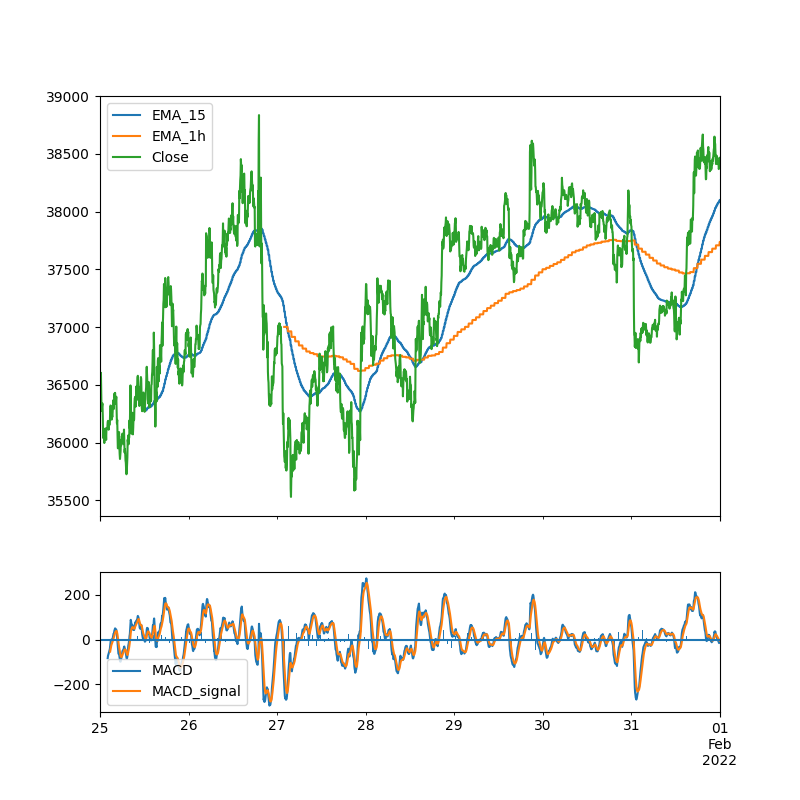

<AxesSubplot:>

In [6]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8,8), gridspec_kw={'height_ratios': [3, 1]})

df[['EMA_15', 'EMA_1h', 'Close']].plot(ax=ax0)

In [7]:
df[['MACD', 'MACD_signal']].plot(ax=ax1)
ax1.axhline(y=0, xmin=0, xmax=1)
ax1.bar(df.index, df['histogram'].values)

<BarContainer object of 2017 artists>

# 5. Code ability to determine higher highs and lower lows on MACD

In [3]:
from scipy.signal import argrelextrema
from collections import deque

def getHigherLows(data: np.array, order=5, K=2):
    '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] < lows[i-1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())
    return extrema
def getLowerHighs(data: np.array, order=5, K=2):
    '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
    high_idx = argrelextrema(data, np.greater, order=order)[0]
    highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if highs[i] > highs[i-1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())
    return extrema
def getHigherHighs(data: np.array, order=5, K=2):
    '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
   '''
  # Get highs
    high_idx = argrelextrema(data, np.greater, order=5)[0]
    highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(high_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if highs[i] < highs[i-1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())
    return extrema
def getLowerLows(data: np.array, order=5, K=2):
    '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
    low_idx = argrelextrema(data, np.less, order=order)[0]
    lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
    extrema = []
    ex_deque = deque(maxlen=K)
    for i, idx in enumerate(low_idx):
        if i == 0:
            ex_deque.append(idx)
            continue
        if lows[i] > lows[i-1]:
            ex_deque.clear()
        ex_deque.append(idx)
        if len(ex_deque) == K:
            extrema.append(ex_deque.copy())
    return extrema

## Bullish Divergence

In [9]:
#Bullish Divergence
order = 5
K = 2

close = df['Close'].values
#hh_close = getHigherHighs(close, order, K)
ll_close = getLowerLows(close, order, K)

macd = df['MACD'].values
hl_macd = getHigherLows(macd, order, K)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

plt.axes(ax0)
_ = [plt.plot(df.index[i], close[i], c='black') for i in ll_close]
df['Close'].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
_ = [plt.plot(df.index[i], macd[i], c='black') for i in hl_macd]
df['MACD'].plot(ax=ax1, alpha=0.5)

## Bearish Divergence

In [260]:
#Bearish Divergence
order = 5
K = 2

close = df['Close'].values
#hh_close = getHigherHighs(close, order, K)
hh_close = getHigherHighs(close, order, K)

macd = df['MACD'].values
lh_macd = getLowerHighs(macd, order, K)

<IPython.core.display.Javascript object>


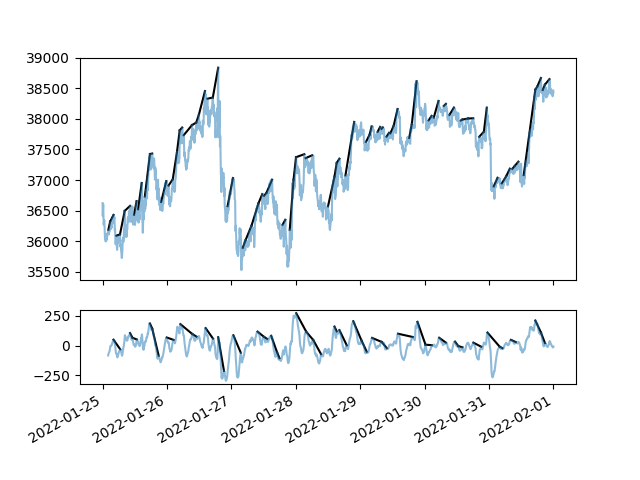

<AxesSubplot:>

In [261]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

plt.axes(ax0)
_ = [plt.plot(df.index[i], close[i], c='black') for i in hh_close]
df['Close'].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
_ = [plt.plot(df.index[i], macd[i], c='black') for i in lh_macd]
df['MACD'].plot(ax=ax1, alpha=0.5)

## Bullish divergence points

In [14]:
divergences = []
i = 0
for pair1 in ll_close:
    for pair2 in hl_macd:
        if (pair2[-1]>pair1[-1]) and (pair2[0]<pair1[-1]):
            divergences.append((i, pair1, pair2))
            i+=1

In [23]:
[(t[0], t[1], t[2], t[2][0]-t[1][0], t[2][-1]-t[1][-1]) for t in divergences]
#below shouldn't be selected
# [1, 3, 4, 15]
#below shold be selected
# [0, 5, 7, 8, 14]
#doubtful
#
#doubtful but might be selected (longer tail trend in macd)
#[2, 6, 9, 10, 11, 12, 13, 16, 17]

[(0, deque([65, 86]), deque([66, 87]), 1, 1),
 (1, deque([258, 267]), deque([260, 303]), 2, 36),
 (2, deque([291, 302]), deque([260, 303]), -31, 1),
 (3, deque([531, 554]), deque([551, 604]), 20, 50),
 (4, deque([554, 606]), deque([604, 624]), 50, 18),
 (5, deque([606, 621]), deque([604, 624]), -2, 3),
 (6, deque([672, 678]), deque([650, 679]), -22, 1),
 (7, deque([797, 810]), deque([797, 811]), 0, 1),
 (8, deque([985, 999]), deque([985, 1004]), 0, 5),
 (9, deque([1127, 1139]), deque([1098, 1146]), -29, 7),
 (10, deque([1198, 1220]), deque([1185, 1225]), -13, 5),
 (11, deque([1366, 1375]), deque([1347, 1376]), -19, 1),
 (12, deque([1514, 1521]), deque([1490, 1523]), -24, 2),
 (13, deque([1586, 1597]), deque([1560, 1598]), -26, 1),
 (14, deque([1688, 1695]), deque([1681, 1698]), -7, 3),
 (15, deque([1742, 1752]), deque([1744, 1782]), 2, 30),
 (16, deque([1770, 1781]), deque([1744, 1782]), -26, 1),
 (17, deque([1800, 1811]), deque([1790, 1814]), -10, 3)]

<IPython.core.display.Javascript object>


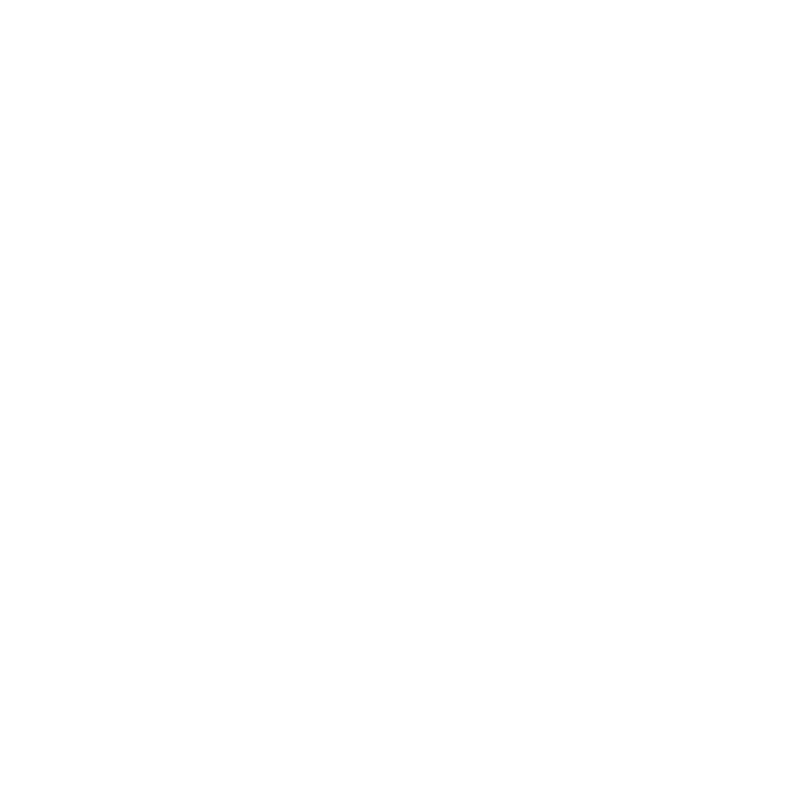

<AxesSubplot:>

In [255]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i = 5
_, ll, hl = divergences[i]
mi = min([min(ll), min(hl)]) - 5
ma = max([max(ll), max(hl)]) + 50

plt.axes(ax0)
plt.plot(df.index[ll], close[ll], c='black')
df['Close'][mi:ma].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
plt.ylim(-300, 100)
plt.plot(df.index[hl], macd[hl], c='black')
ax1.axhline(y=0, xmin=0, xmax=1)
df[['MACD', 'MACD_signal', 'histogram']][mi:ma].plot(ax=ax1, alpha=0.5)

In [61]:
divergences_2 = []
i = 0
for pair1 in ll_close:
    for pair2 in hl_macd:
        if (pair1[-1]>pair2[-1]) and (pair1[0]<pair2[-1]):
            divergences_2.append((i, pair1, pair2))
            i+=1

In [89]:
[(t[0], t[1], t[2], t[2][0]-t[1][0], t[2][-1]-t[1][-1]) for t in divergences_2]
#doesn't look good
# [0, 1, 4, 7, 8, 9, 10, 11, 12]
# shouldnt be selected
#[2, 5, 6]
#should be selected
# [3, ]

[(0, deque([161, 180]), deque([146, 166]), -15, -14),
 (1, deque([213, 234]), deque([184, 218]), -29, -16),
 (2, deque([423, 446]), deque([413, 425]), -10, -21),
 (3, deque([554, 606]), deque([551, 604]), -3, -2),
 (4, deque([810, 827]), deque([797, 811]), -13, -16),
 (5, deque([999, 1017]), deque([985, 1004]), -14, -13),
 (6, deque([1250, 1263]), deque([1240, 1252]), -10, -11),
 (7, deque([1291, 1298]), deque([1276, 1293]), -15, -5),
 (8, deque([1474, 1485]), deque([1453, 1478]), -21, -7),
 (9, deque([1532, 1544]), deque([1523, 1533]), -9, -11),
 (10, deque([1644, 1680]), deque([1618, 1645]), -26, -35),
 (11, deque([1781, 1789]), deque([1744, 1782]), -37, -7),
 (12, deque([1852, 1869]), deque([1842, 1855]), -10, -14)]

<IPython.core.display.Javascript object>


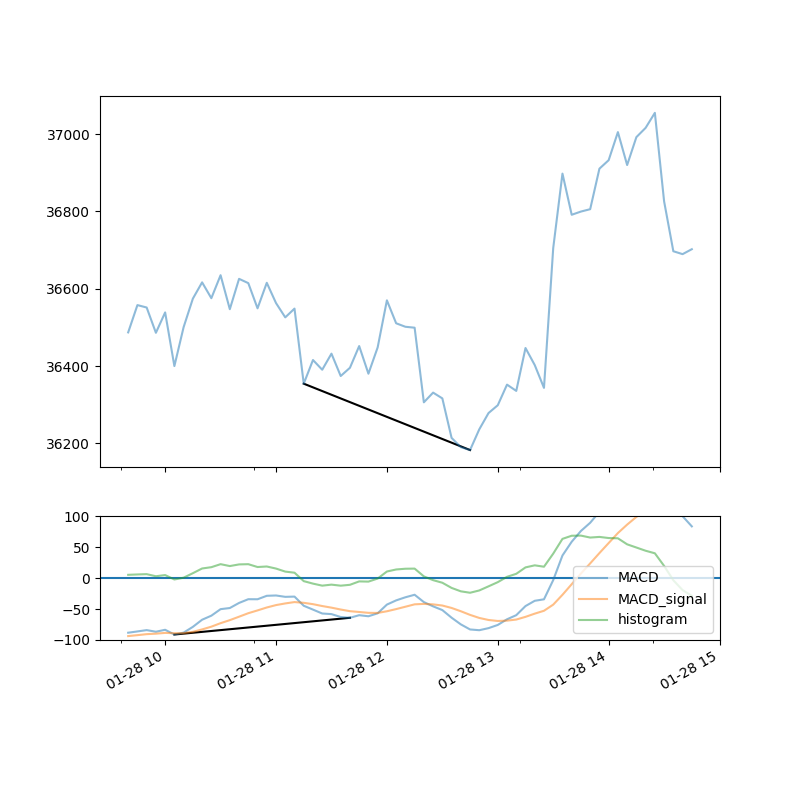

<AxesSubplot:>

In [250]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i = 5
_, ll, hl = divergences_2[i]
mi = min([min(ll), min(hl)]) - 5
ma = max([max(ll), max(hl)]) + 25

plt.axes(ax0)
plt.plot(df.index[ll], close[ll], c='black')
df['Close'][mi:ma].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
plt.ylim(-100, 100)
plt.plot(df.index[hl], macd[hl], c='black')
ax1.axhline(y=0, xmin=0, xmax=1)
df[['MACD', 'MACD_signal', 'histogram']][mi:ma].plot(ax=ax1, alpha=0.5)

In [161]:
divergences_3 = []
i = 0
for pair1 in ll_close:
    for pair2 in hl_macd:
        if (pair2[-1]-pair1[-1]<8) and (pair2[-1]-pair1[-1]>-3):
            divergences_3.append((i, pair1, pair2))
            i+=1

In [162]:
[(t[0], t[1], t[2], t[2][0]-t[1][0], t[2][-1]-t[1][-1]) for t in divergences_3]

[(0, deque([65, 86]), deque([66, 87]), 1, 1),
 (1, deque([291, 302]), deque([260, 303]), -31, 1),
 (2, deque([554, 606]), deque([551, 604]), -3, -2),
 (3, deque([606, 621]), deque([604, 624]), -2, 3),
 (4, deque([672, 678]), deque([650, 679]), -22, 1),
 (5, deque([797, 810]), deque([797, 811]), 0, 1),
 (6, deque([968, 985]), deque([969, 985]), 1, 0),
 (7, deque([985, 999]), deque([985, 1004]), 0, 5),
 (8, deque([1127, 1139]), deque([1098, 1146]), -29, 7),
 (9, deque([1172, 1185]), deque([1175, 1185]), 3, 0),
 (10, deque([1198, 1220]), deque([1185, 1225]), -13, 5),
 (11, deque([1366, 1375]), deque([1347, 1376]), -19, 1),
 (12, deque([1514, 1521]), deque([1490, 1523]), -24, 2),
 (13, deque([1586, 1597]), deque([1560, 1598]), -26, 1),
 (14, deque([1688, 1695]), deque([1681, 1698]), -7, 3),
 (15, deque([1770, 1781]), deque([1744, 1782]), -26, 1),
 (16, deque([1800, 1811]), deque([1790, 1814]), -10, 3)]

<IPython.core.display.Javascript object>


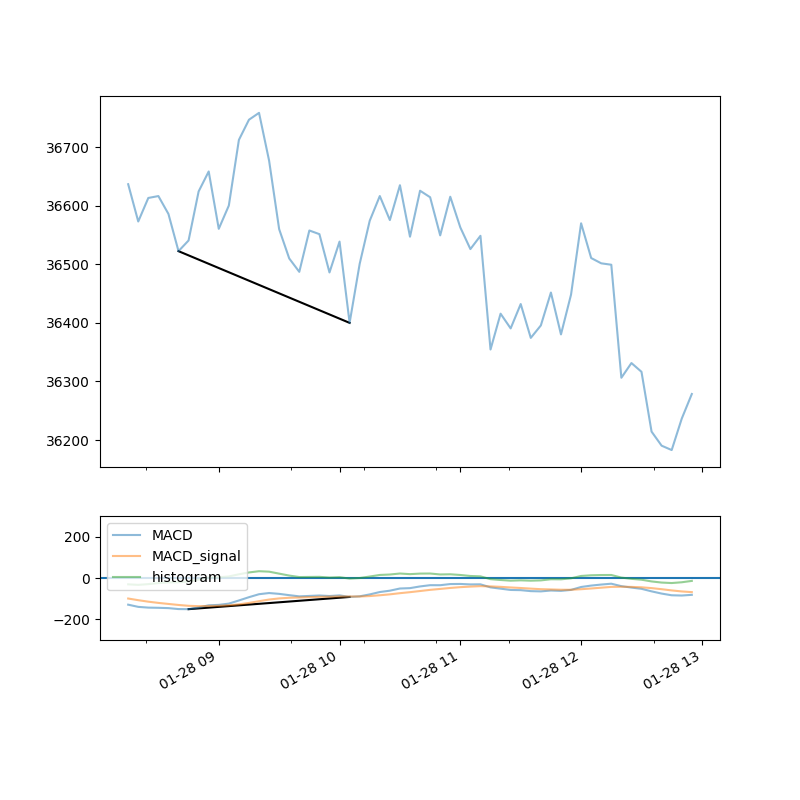

<AxesSubplot:>

In [184]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i = 6
_, ll, hl = divergences_3[i]
mi = min([min(ll), min(hl)]) - 5
ma = max([max(ll), max(hl)]) + 35

plt.axes(ax0)
plt.plot(df.index[ll], close[ll], c='black')
df['Close'][mi:ma].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
plt.ylim(-300, 300)
plt.plot(df.index[hl], macd[hl], c='black')
ax1.axhline(y=0, xmin=0, xmax=1)
df[['MACD', 'MACD_signal', 'histogram']][mi:ma].plot(ax=ax1, alpha=0.5)

In [105]:
start

Timestamp('2022-01-25 00:00:00')

In [256]:
s = '2022-01-27 02:30:00'
e = '2022-01-27 04:00:00'

In [257]:
df.loc[s:e, :]

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx
2022-01-27 02:30:00,35756.97,37036.546553,37001.643055,-267.367604,-228.398977,-38.968627,-46.292417,Null,True,True,True,0,41,606
2022-01-27 02:35:00,35807.12,37036.546553,37001.643055,-262.214842,-235.162150,-27.052692,-38.968627,Null,True,True,True,0,41,607
2022-01-27 02:40:00,35845.05,36989.821198,37001.643055,-252.163820,-238.562484,-13.601335,-27.052692,Null,False,True,True,0,41,608
2022-01-27 02:45:00,36004.37,36989.821198,37001.643055,-228.706138,-236.591215,7.885077,-13.601335,Shift,False,True,True,1,42,609
2022-01-27 02:50:00,35960.00,36989.821198,37001.643055,-211.260761,-231.525124,20.264363,7.885077,Null,False,True,True,0,42,610
2022-01-27 02:55:00,36008.69,36951.345465,36962.703720,-191.301098,-223.480319,32.179221,20.264363,Null,False,True,True,0,42,611
2022-01-27 03:00:00,36073.12,36951.345465,36962.703720,-168.343401,-212.452935,44.109534,32.179221,Null,False,True,True,0,42,612
2022-01-27 03:05:00,36213.11,36951.345465,36962.703720,-137.270865,-197.416521,60.145656,44.109534,Null,False,True,True,0,42,613
2022-01-27 03:10:00,36114.55,36918.529956,36962.703720,-119.224281,-181.778073,62.553792,60.145656,Null,False,True,True,0,42,614
2022-01-27 03:15:00,36187.83,36918.529956,36962.703720,-97.880840,-164.998627,67.117786,62.553792,Null,False,True,True,0,42,615


<IPython.core.display.Javascript object>


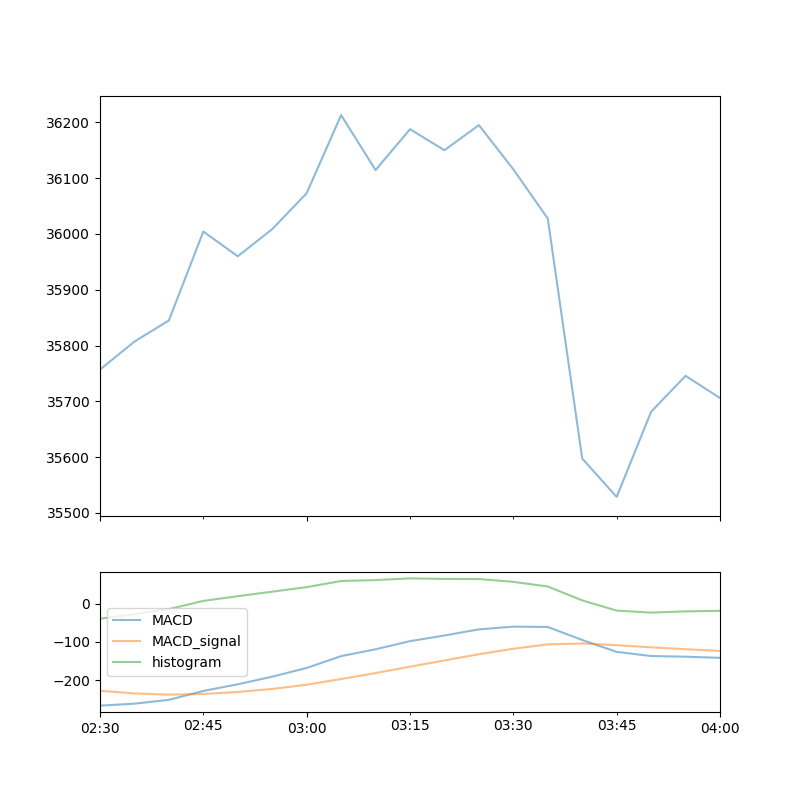

<AxesSubplot:>

In [118]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i = 9
#_, ll, hl = divergences_3[i]
#mi = min([min(ll), min(hl)]) - 5
#ma = max([max(ll), max(hl)]) + 25

plt.axes(ax0)
#plt.plot(df.index[ll], close[ll], c='black')
df['Close'][s:e].plot(ax=ax0, alpha=0.5)


In [119]:

plt.axes(ax1)
#plt.ylim(-100, 300)
#plt.plot(df.index[hl], macd[hl], c='black')
#ax1.axhline(y=0, xmin=0, xmax=1)
df[['MACD', 'MACD_signal', 'histogram']][s:e].plot(ax=ax1, alpha=0.5)

<AxesSubplot:>

In [292]:
divergences_4 = []
i = 0
for pair1 in ll_close:
    for pair2 in hl_macd:
        if (pair2[-1]-pair1[-1]<8) and (pair2[-1]-pair1[-1]>-3) and (pair2[0]-pair1[0]>-25):
            divergences_4.append((i, pair1, pair2))
            i+=1

In [293]:
[(t[0], t[1], t[2], t[2][0]-t[1][0], t[2][-1]-t[1][-1]) for t in divergences_4]

[(0, deque([65, 86]), deque([66, 87]), 1, 1),
 (1, deque([554, 606]), deque([551, 604]), -3, -2),
 (2, deque([606, 621]), deque([604, 624]), -2, 3),
 (3, deque([672, 678]), deque([650, 679]), -22, 1),
 (4, deque([797, 810]), deque([797, 811]), 0, 1),
 (5, deque([968, 985]), deque([969, 985]), 1, 0),
 (6, deque([985, 999]), deque([985, 1004]), 0, 5),
 (7, deque([1172, 1185]), deque([1175, 1185]), 3, 0),
 (8, deque([1198, 1220]), deque([1185, 1225]), -13, 5),
 (9, deque([1366, 1375]), deque([1347, 1376]), -19, 1),
 (10, deque([1514, 1521]), deque([1490, 1523]), -24, 2),
 (11, deque([1688, 1695]), deque([1681, 1698]), -7, 3),
 (12, deque([1800, 1811]), deque([1790, 1814]), -10, 3)]

<IPython.core.display.Javascript object>


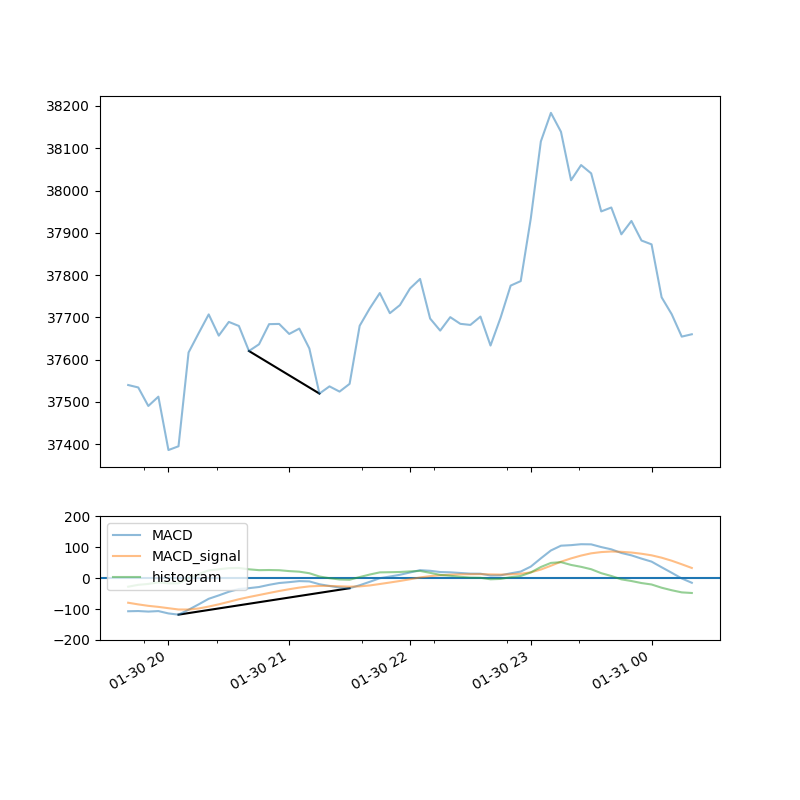

<AxesSubplot:>

In [298]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i = 11
_, ll, hl = divergences_4[i]
mi = min([min(ll), min(hl)]) - 5
ma = max([max(ll), max(hl)]) + 35

plt.axes(ax0)
plt.plot(df.index[ll], close[ll], c='black')
df['Close'][mi:ma].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
plt.ylim(-200, 200)
plt.plot(df.index[hl], macd[hl], c='black')
ax1.axhline(y=0, xmin=0, xmax=1)
df[['MACD', 'MACD_signal', 'histogram']][mi:ma].plot(ax=ax1, alpha=0.5)

## Bearish divergence points

In [264]:
divergences_bearish = []
i = 0
for pair1 in hh_close:
    for pair2 in lh_macd:
        if (pair2[-1]-pair1[-1]<8) and (pair2[-1]-pair1[-1]>-3) and (pair2[0]-pair1[0]>-25):
            divergences_bearish.append((i, pair1, pair2))
            i+=1

In [265]:
[(t[0], t[1], t[2], t[2][0]-t[1][0], t[2][-1]-t[1][-1]) for t in divergences_bearish]

[(0, deque([62, 78]), deque([49, 79]), -13, 1),
 (1, deque([141, 152]), deque([134, 153]), -7, 1),
 (2, deque([212, 222]), deque([212, 222]), 0, 0),
 (3, deque([295, 314]), deque([287, 318]), -8, 4),
 (4, deque([363, 400]), deque([348, 401]), -15, 1),
 (5, deque([400, 419]), deque([401, 420]), 1, 1),
 (6, deque([469, 493]), deque([461, 494]), -8, 1),
 (7, deque([722, 733]), deque([722, 736]), 0, 3),
 (8, deque([908, 937]), deque([911, 942]), 3, 5),
 (9, deque([1037, 1047]), deque([1037, 1047]), 0, 0),
 (10, deque([1458, 1471]), deque([1444, 1472]), -14, 1),
 (11, deque([1526, 1535]), deque([1505, 1535]), -21, 0),
 (12, deque([1602, 1608]), deque([1591, 1609]), -11, 1),
 (13, deque([1832, 1843]), deque([1826, 1848]), -6, 5),
 (14, deque([1944, 1960]), deque([1935, 1960]), -9, 0),
 (15, deque([1968, 1978]), deque([1960, 1978]), -8, 0)]

<IPython.core.display.Javascript object>


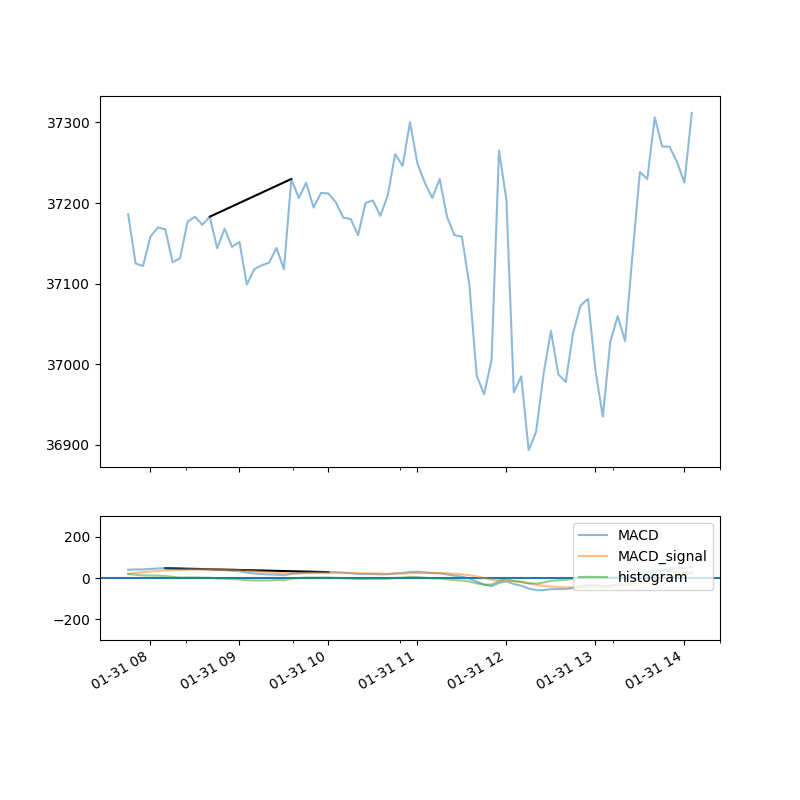

<AxesSubplot:>

In [288]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

i = 13
_, hh, lh = divergences_bearish[i]
mi = min([min(hh), min(lh)]) - 5
ma = max([max(hh), max(lh)]) + 50

plt.axes(ax0)
plt.plot(df.index[hh], close[hh], c='black')
df['Close'][mi:ma].plot(ax=ax0, alpha=0.5)

plt.axes(ax1)
plt.ylim(-300, 300)
plt.plot(df.index[lh], macd[lh], c='black')
ax1.axhline(y=0, xmin=0, xmax=1)
df[['MACD', 'MACD_signal', 'histogram']][mi:ma].plot(ax=ax1, alpha=0.5)

# 6. Add entry and exit logics

#### Bullish Divergence - Long Trade - 
1. EMA_15 > EMA_1h
2. MACD, signal < 0
3. Bullish Divergence
 * Lower Low on the price action at the *same time*(doesn't hold completerly) Higher Low on MACD line
4. In-between this divergence occurance, **MACD, signal < 0(not touch zero line of histogram)**
5. Need to see gap in histogram (red-green-red)
6. entry - cross of the macd in the direction of the signal

#### Bearish Divergence - Short Trade -
1. EMA_15 < EMA_1h
2. MACD, signal > 0
3. Bearish Divergence 
 * Higher High on the price action at the *same time*(doesn't hold completerly) Lower High on MACD line
4. In-between this divergence occurance, **MACD, signal > 0(not touch zero line of histogram)**
5. Need to see gap in histogram (green-red-green)
6. entry - cross of the macd in the direction of the signal

In [4]:
# function to identify signal
def gap(s):
    
    previos_val = s['shifted_hist']
    current_val = s['histogram']
    
    if previos_val is np.nan:
        return 'Null'
    if (previos_val < 0) and (current_val >= 0):
        return 'Shift'
    elif (previos_val > 0) and (current_val <= 0):
        return 'Shift'
    else:
        return 'Null'

In [354]:
df['shifted_hist'] = df['histogram'].shift(1)
df['histogram_2g'] = df[['histogram', 'shifted_hist']].apply(gap, axis=1)
df['histogram_2g_bi'] = np.where(df['histogram_2g']=='Shift', 1, 0)
df['histogram_2g_cumsum'] = df['histogram_2g_bi'].cumsum()
df

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx,EMA_15<EMA_1h,MACD>0,MACD_signal>0
2022-01-25 00:00:00,36622.03,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,0,False,False,False
2022-01-25 00:05:00,36410.86,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,1,False,False,False
2022-01-25 00:10:00,36496.76,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,2,False,False,False
2022-01-25 00:15:00,36603.61,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,3,False,False,False
2022-01-25 00:20:00,36427.06,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,4,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629,-12.020245,0.181841,-12.202086,-9.346690,Null,True,True,False,0,159,2012,False,False,True
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629,-15.683966,-2.991320,-12.692646,-12.202086,Null,True,True,True,0,159,2013,False,False,False
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629,-11.397207,-4.672498,-6.724710,-12.692646,Null,True,True,True,0,159,2014,False,False,False
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252,-7.912741,-5.320547,-2.592195,-6.724710,Null,True,True,True,0,159,2015,False,False,False


In [130]:
vc = df['histogram_2g'].value_counts()
vc

Null     1858
Shift     159
Name: histogram_2g, dtype: int64

In [202]:
'Shift' in vc.index

True

## Bullish Conditions

In [128]:
df['EMA_15>EMA_1h'] = df['EMA_15'] > df['EMA_1h']
df['MACD<0'] = df['MACD']<0
df['MACD_signal<0'] = df['MACD_signal']<0
df

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0
2022-01-25 00:00:00,36622.03,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False
2022-01-25 00:05:00,36410.86,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False
2022-01-25 00:10:00,36496.76,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False
2022-01-25 00:15:00,36603.61,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False
2022-01-25 00:20:00,36427.06,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629,-12.020245,0.181841,-12.202086,-9.346690,Null,True,True,False
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629,-15.683966,-2.991320,-12.692646,-12.202086,Null,True,True,True
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629,-11.397207,-4.672498,-6.724710,-12.692646,Null,True,True,True
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252,-7.912741,-5.320547,-2.592195,-6.724710,Null,True,True,True


In [172]:
divergences_4

[(0, deque([65, 86]), deque([66, 87])),
 (1, deque([554, 606]), deque([551, 604])),
 (2, deque([606, 621]), deque([604, 624])),
 (3, deque([672, 678]), deque([650, 679])),
 (4, deque([797, 810]), deque([797, 811])),
 (5, deque([968, 985]), deque([969, 985])),
 (6, deque([985, 999]), deque([985, 1004])),
 (7, deque([1172, 1185]), deque([1175, 1185])),
 (8, deque([1198, 1220]), deque([1185, 1225])),
 (9, deque([1366, 1375]), deque([1347, 1376])),
 (10, deque([1514, 1521]), deque([1490, 1523])),
 (11, deque([1688, 1695]), deque([1681, 1698])),
 (12, deque([1800, 1811]), deque([1790, 1814]))]

In [237]:
i = 2
df.iloc[divergences_4[i][2][0]:divergences_4[i][2][-1]+1, :]
#df.iloc[969:985, :]

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum
2022-01-27 02:20:00,35777.32,37084.969678,37001.643055,-267.499187,-207.083717,-60.415470,-67.464631,Null,True,True,True,0,41
2022-01-27 02:25:00,35850.18,37036.546553,37001.643055,-264.949237,-218.656821,-46.292417,-60.415470,Null,True,True,True,0,41
2022-01-27 02:30:00,35756.97,37036.546553,37001.643055,-267.367604,-228.398977,-38.968627,-46.292417,Null,True,True,True,0,41
2022-01-27 02:35:00,35807.12,37036.546553,37001.643055,-262.214842,-235.162150,-27.052692,-38.968627,Null,True,True,True,0,41
2022-01-27 02:40:00,35845.05,36989.821198,37001.643055,-252.163820,-238.562484,-13.601335,-27.052692,Null,False,True,True,0,41
2022-01-27 02:45:00,36004.37,36989.821198,37001.643055,-228.706138,-236.591215,7.885077,-13.601335,Shift,False,True,True,1,42
2022-01-27 02:50:00,35960.00,36989.821198,37001.643055,-211.260761,-231.525124,20.264363,7.885077,Null,False,True,True,0,42
2022-01-27 02:55:00,36008.69,36951.345465,36962.703720,-191.301098,-223.480319,32.179221,20.264363,Null,False,True,True,0,42
2022-01-27 03:00:00,36073.12,36951.345465,36962.703720,-168.343401,-212.452935,44.109534,32.179221,Null,False,True,True,0,42
2022-01-27 03:05:00,36213.11,36951.345465,36962.703720,-137.270865,-197.416521,60.145656,44.109534,Null,False,True,True,0,42


In [210]:
df[['histogram_2g', 'histogram_2g_cumsum']][divergences_4[5][2][0]:divergences_4[5][2][-1]]

,histogram_2g,histogram_2g_cumsum
2022-01-28 08:45:00,Null,69
2022-01-28 08:50:00,Null,69
2022-01-28 08:55:00,Shift,70
2022-01-28 09:00:00,Null,70
2022-01-28 09:05:00,Null,70
2022-01-28 09:10:00,Null,70
2022-01-28 09:15:00,Null,70
2022-01-28 09:20:00,Null,70
2022-01-28 09:25:00,Null,70
2022-01-28 09:30:00,Null,70


In [204]:
#Something to come back to
for t in divergences_4:
    val_count = df['histogram_2g'][t[2][0]:t[2][-1]].value_counts()
    if not 'Shift' in val_count.index:
        print('{} dont have Shift'.format(t[0]))
        continue
    if val_count['Shift'] == 1:
        print('{} have only 1 Shift'.format(t[0]))
        continue
    if val_count['Shift'] == 2:
        print('{} is of use'.format(t[0]))
    #print(s)

0 is of use
1 is of use
2 is of use
3 have only 1 Shift
4 is of use
5 have only 1 Shift
7 dont have Shift
8 is of use
9 is of use
10 is of use
11 is of use
12 is of use


In [219]:
for t in divergences_4:
    i, _, macd_ll_pair = t
    s = macd_ll_pair[0]
    e = macd_ll_pair[-1]
    #indexing problem
    dif = df['histogram_2g_cumsum'][e]-df['histogram_2g_cumsum'][s]
    #print(df.index[e], df.index[s])
    if dif == 0:
        print('{} dont have Shift'.format(i))
    if dif == 1:
        print('{} have 1 Shift'.format(i))
    if dif ==2:
        print('{} is of use'.format(i))
        

0 is of use
1 is of use
2 is of use
3 have 1 Shift
4 is of use
5 is of use
6 is of use
7 dont have Shift
8 is of use
9 is of use
10 is of use
11 is of use
12 is of use


In [222]:
_ = df.loc['2022-01-28 08:45:00':'2022-01-28 10:05:00'].copy()
_

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum
2022-01-28 08:45:00,36540.68,36881.684359,36756.564871,-150.331604,-134.062920,-16.268684,-19.889287,Null,True,True,True,0,69
2022-01-28 08:50:00,36624.42,36881.684359,36756.564871,-142.288185,-135.707973,-6.580212,-16.268684,Null,True,True,True,0,69
2022-01-28 08:55:00,36658.47,36872.930855,36752.718013,-131.648604,-134.896099,3.247495,-6.580212,Shift,True,True,True,1,70
2022-01-28 09:00:00,36560.58,36872.930855,36752.718013,-129.621370,-133.841153,4.219784,3.247495,Null,True,True,True,0,70
2022-01-28 09:05:00,36600.27,36872.930855,36752.718013,-123.389760,-131.750875,8.361114,4.219784,Null,True,True,True,0,70
2022-01-28 09:10:00,36712.37,36866.634351,36752.718013,-108.158844,-127.032469,18.873625,8.361114,Null,True,True,True,0,70
2022-01-28 09:15:00,36746.81,36866.634351,36752.718013,-92.245860,-120.075147,27.829287,18.873625,Null,True,True,True,0,70
2022-01-28 09:20:00,36758.54,36866.634351,36752.718013,-77.791461,-111.618410,33.826949,27.829287,Null,True,True,True,0,70
2022-01-28 09:25:00,36677.01,36859.198102,36752.718013,-72.084095,-103.711547,31.627452,33.826949,Null,True,True,True,0,70
2022-01-28 09:30:00,36559.99,36859.198102,36752.718013,-76.125969,-98.194431,22.068462,31.627452,Null,True,True,True,0,70


In [227]:
_['EMA_15>EMA_1h'].sum() == len(_), _['MACD<0'].sum() == len(_), _['MACD_signal<0'].sum() == len(_)

(True, True, True)

In [246]:
df['indx'] = pd.RangeIndex(len(df))
df

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx
2022-01-25 00:00:00,36622.03,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,0
2022-01-25 00:05:00,36410.86,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,1
2022-01-25 00:10:00,36496.76,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,2
2022-01-25 00:15:00,36603.61,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,3
2022-01-25 00:20:00,36427.06,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629,-12.020245,0.181841,-12.202086,-9.346690,Null,True,True,False,0,159,2012
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629,-15.683966,-2.991320,-12.692646,-12.202086,Null,True,True,True,0,159,2013
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629,-11.397207,-4.672498,-6.724710,-12.692646,Null,True,True,True,0,159,2014
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252,-7.912741,-5.320547,-2.592195,-6.724710,Null,True,True,True,0,159,2015


In [300]:
points_count = 0
long_points = []

for t in divergences_4:
    i, _, macd_ll_pair = t
    s = macd_ll_pair[0]
    e = macd_ll_pair[-1]
    dif = df['histogram_2g_cumsum'][e]-df['histogram_2g_cumsum'][s]
    if not dif >= 2:
        continue
    points_count+= 1
    #print('DataPoint number {} : Conditions Checking'.format(i))
    df_ll = df.iloc[s:e+1].copy()
        
    condition_1 = df_ll['EMA_15>EMA_1h'].sum() == len(df_ll)
    condition_2 = df_ll['MACD<0'].sum() == len(df_ll)
    condition_3 = df_ll['MACD_signal<0'].sum() == len(df_ll)
    #print('\tcondition 1 is {}'.format(condition_1))
    #print('\tcondition 2 is {}'.format(condition_2))
    #print('\tcondition 3 is {}'.format(condition_3))
    if (condition_1 and condition_2 and condition_3):
        entry_point = df[df['histogram_2g_cumsum'] == df['histogram_2g_cumsum'][e] + 1].index[0]
        entry_point = df['indx'][entry_point]
        long_points.append(entry_point)
        print(i, e, entry_point, entry_point-e)
    
    
        
print(long_points)

5 985 986 1
6 1004 1008 4
11 1698 1699 1
[986, 1008, 1699]


## Bearish Conditions

In [271]:
df['EMA_15<EMA_1h'] = df['EMA_15'] < df['EMA_1h']
df['MACD>0'] = df['MACD']>0
df['MACD_signal>0'] = df['MACD_signal']>0
df

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx,EMA_15<EMA_1h,MACD>0,MACD_signal>0
2022-01-25 00:00:00,36622.03,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,0,False,False,False
2022-01-25 00:05:00,36410.86,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,1,False,False,False
2022-01-25 00:10:00,36496.76,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,2,False,False,False
2022-01-25 00:15:00,36603.61,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,3,False,False,False
2022-01-25 00:20:00,36427.06,NaN,NaN,NaN,NaN,NaN,NaN,Null,False,False,False,0,0,4,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629,-12.020245,0.181841,-12.202086,-9.346690,Null,True,True,False,0,159,2012,False,False,True
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629,-15.683966,-2.991320,-12.692646,-12.202086,Null,True,True,True,0,159,2013,False,False,False
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629,-11.397207,-4.672498,-6.724710,-12.692646,Null,True,True,True,0,159,2014,False,False,False
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252,-7.912741,-5.320547,-2.592195,-6.724710,Null,True,True,True,0,159,2015,False,False,False


In [281]:
divergences_bearish[i]

(15, deque([1968, 1978]), deque([1960, 1978]))

In [283]:
i = 14
df.iloc[divergences_bearish[i][2][0]:divergences_bearish[i][2][-1]+1, :]
#df.iloc[969:985, :]

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx,EMA_15<EMA_1h,MACD>0,MACD_signal>0
2022-01-31 17:15:00,38477.69,37440.949550,37510.355750,211.206955,174.115176,37.091779,33.584148,Null,False,False,False,0,150,1935,True,True,True
2022-01-31 17:20:00,38363.99,37440.949550,37510.355750,209.743224,181.240786,28.502438,37.091779,Null,False,False,False,0,150,1936,True,True,True
2022-01-31 17:25:00,38347.00,37476.480940,37510.355750,204.850862,185.962801,18.888061,28.502438,Null,False,False,False,0,150,1937,True,True,True
2022-01-31 17:30:00,38312.54,37476.480940,37510.355750,195.934387,187.957118,7.977268,18.888061,Null,False,False,False,0,150,1938,True,True,True
2022-01-31 17:35:00,38358.38,37476.480940,37510.355750,190.372426,188.440180,1.932246,7.977268,Null,False,False,False,0,150,1939,True,True,True
2022-01-31 17:40:00,38415.96,37513.323256,37510.355750,188.438554,188.439854,-0.001301,1.932246,Shift,True,False,False,1,151,1940,False,True,True
2022-01-31 17:45:00,38511.56,37513.323256,37510.355750,192.402175,189.232319,3.169857,-0.001301,Shift,True,False,False,1,152,1941,False,True,True
2022-01-31 17:50:00,38460.91,37513.323256,37510.355750,189.274503,189.240755,0.033748,3.169857,Null,True,False,False,0,152,1942,False,True,True
2022-01-31 17:55:00,38473.03,37550.958815,37548.107681,185.633911,188.519387,-2.885476,0.033748,Shift,True,False,False,1,153,1943,False,True,True
2022-01-31 18:00:00,38530.01,37550.958815,37548.107681,185.211522,187.857814,-2.646291,-2.885476,Null,True,False,False,0,153,1944,False,True,True


In [278]:
#Something to come back to
for t in divergences_bearish:
    val_count = df['histogram_2g'][t[2][0]:t[2][-1]].value_counts()
    if not 'Shift' in val_count.index:
        print('{} dont have Shift'.format(t[0]))
        continue
    if val_count['Shift'] == 1:
        print('{} have only 1 Shift'.format(t[0]))
        continue
    if val_count['Shift'] == 2:
        print('{} is of use'.format(t[0]))
    else:
        print('{} has {} shifts'.format(t[0], val_count['Shift']))
    #print(s)

0 is of use
1 has 3 shifts
2 have only 1 Shift
3 is of use
4 is of use
5 is of use
6 is of use
7 is of use
8 has 4 shifts
9 is of use
10 is of use
11 has 4 shifts
12 have only 1 Shift
13 is of use
14 has 3 shifts
15 has 3 shifts


In [275]:
for t in divergences_bearish:
    i, _, macd_hh_pair = t
    s = macd_hh_pair[0]
    e = macd_hh_pair[-1]
    #indexing problem
    dif = df['histogram_2g_cumsum'][e]-df['histogram_2g_cumsum'][s]
    #print(df.index[e], df.index[s])
    if dif == 0:
        print('{} dont have Shift'.format(i))
    if dif == 1:
        print('{} have 1 Shift'.format(i))
    if dif ==2:
        print('{} is of use'.format(i))
        

0 is of use
1 is of use
2 have 1 Shift
3 is of use
4 is of use
5 is of use
6 is of use
7 is of use
9 is of use
10 is of use
12 have 1 Shift
13 is of use
15 is of use


In [299]:
points_count = 0
short_points = []
for t in divergences_bearish:
    i, _, macd_hh_pair = t
    s = macd_hh_pair[0]
    e = macd_hh_pair[-1]
    dif = df['histogram_2g_cumsum'][e]-df['histogram_2g_cumsum'][s]
    if not dif >= 2:
        continue
    points_count+= 1
    print('DataPoint number {} : Conditions Checking'.format(i))
    df_hh = df.iloc[s:e+1].copy()
        
    condition_1 = df_hh['EMA_15<EMA_1h'].sum() == len(df_hh)
    condition_2 = df_hh['MACD>0'].sum() == len(df_hh)
    condition_3 = df_hh['MACD_signal>0'].sum() == len(df_hh)
    print('\tcondition 1 is {}'.format(condition_1))
    print('\tcondition 2 is {}'.format(condition_2))
    print('\tcondition 3 is {}'.format(condition_3))
    if (condition_1 and condition_2 and condition_3):
        entry_point = df[df['histogram_2g_cumsum'] == df['histogram_2g_cumsum'][e] + 1].index[0]
        entry_point = df['indx'][entry_point]
        short_points.append(entry_point)
        print(i, e, entry_point, entry_point-e)
    
    
        
print(short_points)

DataPoint number 0 : Conditions Checking
	condition 1 is False
	condition 2 is False
	condition 3 is False
DataPoint number 1 : Conditions Checking
	condition 1 is False
	condition 2 is False
	condition 3 is True
DataPoint number 3 : Conditions Checking
	condition 1 is False
	condition 2 is False
	condition 3 is False
DataPoint number 4 : Conditions Checking
	condition 1 is False
	condition 2 is False
	condition 3 is False
DataPoint number 5 : Conditions Checking
	condition 1 is False
	condition 2 is True
	condition 3 is True
DataPoint number 6 : Conditions Checking
	condition 1 is False
	condition 2 is False
	condition 3 is False
DataPoint number 7 : Conditions Checking
	condition 1 is True
	condition 2 is True
	condition 3 is True
7 736 738 2
DataPoint number 8 : Conditions Checking
	condition 1 is False
	condition 2 is False
	condition 3 is True
DataPoint number 9 : Conditions Checking
	condition 1 is True
	condition 2 is True
	condition 3 is True
9 1047 1050 3
DataPoint number 10 :

In [359]:
long_points

[986, 1008, 1699]

In [413]:
i = 2
entry = long_points[i]
df_en = df[entry:].copy()
_ = df.iloc[entry]['Close']*0.5/100
loss = df.iloc[entry]['Close']-_
profit = df.iloc[entry]['Close']+2*_
loss, _, profit, 2*_

(37491.669649999996, 188.40035, 38056.8707, 376.8007)

In [414]:
df_en['diff'] = df_en['Close'] - df.iloc[entry]['Close']
df_en

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx,EMA_15<EMA_1h,MACD>0,MACD_signal>0,diff
2022-01-30 21:35:00,37680.07,37836.302602,37744.081590,-22.846155,-26.500665,3.654510,-5.054657,Shift,True,True,True,1,130,1699,False,False,False,0.00
2022-01-30 21:40:00,37721.10,37831.784853,37744.081590,-11.773526,-23.555237,11.781711,3.654510,Null,True,True,True,0,130,1700,False,False,False,41.03
2022-01-30 21:45:00,37757.52,37831.784853,37744.081590,-0.058918,-18.855973,18.797055,11.781711,Null,True,True,True,0,130,1701,False,False,False,77.45
2022-01-30 21:50:00,37709.86,37831.784853,37744.081590,5.317927,-14.021193,19.339120,18.797055,Null,True,False,True,0,130,1702,False,True,False,29.79
2022-01-30 21:55:00,37729.00,37827.754075,37743.490155,10.996790,-9.017597,20.014386,19.339120,Null,True,False,True,0,130,1703,False,True,False,48.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 14:20:00,37309.79,37186.270406,37464.534426,64.633376,46.054186,18.579190,22.582300,Null,False,False,False,0,146,1900,True,True,True,-370.28
2022-01-31 14:25:00,37352.41,37192.785684,37464.534426,67.799445,50.403238,17.396208,18.579190,Null,False,False,False,0,146,1901,True,True,True,-327.66
2022-01-31 14:30:00,37447.26,37192.785684,37464.534426,77.073723,55.737335,21.336388,17.396208,Null,False,False,False,0,146,1902,True,True,True,-232.81
2022-01-31 14:35:00,37392.25,37192.785684,37464.534426,79.073299,60.404528,18.668772,21.336388,Null,False,False,False,0,146,1903,True,True,True,-287.82


In [382]:
df_en[['Close', 'histogram_2g_bi', 'indx', 'diff']]

,Close,histogram_2g_bi,indx,diff
2022-01-30 21:35:00,37680.07,1,1699,0.00
2022-01-30 21:40:00,37721.10,0,1700,41.03
2022-01-30 21:45:00,37757.52,0,1701,77.45
2022-01-30 21:50:00,37709.86,0,1702,29.79
2022-01-30 21:55:00,37729.00,0,1703,48.93
2022-01-30 22:00:00,37768.27,0,1704,88.20
2022-01-30 22:05:00,37790.88,0,1705,110.81
2022-01-30 22:10:00,37697.14,0,1706,17.07
2022-01-30 22:15:00,37668.64,0,1707,-11.43
2022-01-30 22:20:00,37700.47,0,1708,20.40


In [383]:
df_en.loc[df_en['diff'] >= 2*_, ['Close', 'histogram_2g_bi', 'indx', 'diff']]['indx'].iloc[0]

1717

In [384]:
df_en.loc[df_en['diff'] <= -_, ['Close', 'histogram_2g_bi', 'indx', 'diff']]['indx'].iloc[0]

1736

In [385]:
short_points

[738, 1050, 1850]

In [435]:
i = 1
entry = short_points[i]
df_en = df[entry:].copy()
_ = df.iloc[entry]['Close']*0.5/100
loss = df.iloc[entry]['Close']+_
profit = df.iloc[entry]['Close']-2*_
loss, _, profit, 2*_

(37080.48, 184.48, 36527.04, 368.96)

In [436]:
df_en['diff'] = df_en['Close'] - df.iloc[entry]['Close']
#df_en

In [437]:
df_en[['Close', 'histogram_2g_bi', 'indx', 'diff']]

,Close,histogram_2g_bi,indx,diff
2022-01-28 15:30:00,36896.00,1,1050,0.00
2022-01-28 15:35:00,37050.02,0,1051,154.02
2022-01-28 15:40:00,37022.42,0,1052,126.42
2022-01-28 15:45:00,37195.50,1,1053,299.50
2022-01-28 15:50:00,37242.01,0,1054,346.01
...,...,...,...,...
2022-01-31 23:40:00,38369.11,0,2012,1473.11
2022-01-31 23:45:00,38379.47,0,2013,1483.47
2022-01-31 23:50:00,38466.95,0,2014,1570.95
2022-01-31 23:55:00,38466.90,0,2015,1570.90


In [438]:
df_en.loc[df_en['diff'] <= -2*_, ['Close', 'histogram_2g_bi', 'indx', 'diff']]['indx']#.iloc[0]

Series([], Name: indx, dtype: int64)

In [434]:
df_en.loc[df_en['diff'] >= _, ['Close', 'histogram_2g_bi', 'indx', 'diff']]['indx'].iloc[0]

741

# 7. Calculate returns (on atleast last 3 years data)

In [305]:
2:1, 2 pips 0.5 
    100, 1 
    0.5% 2:1 (0.5 close)

SyntaxError: invalid syntax (257762869.py, line 1)

In [312]:
df_en = df[531:]
df_en

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,EMA_15>EMA_1h,MACD<0,MACD_signal<0,histogram_2g_bi,histogram_2g_cumsum,indx,EMA_15<EMA_1h,MACD>0,MACD_signal>0
2022-01-26 20:15:00,36804.17,37812.515748,NaN,-241.790575,-121.080061,-120.710514,-103.438563,Null,False,True,True,0,37,531,False,False,False
2022-01-26 20:20:00,36892.70,37812.515748,NaN,-269.148501,-150.693749,-118.454752,-120.710514,Null,False,True,True,0,37,532,False,False,False
2022-01-26 20:25:00,37188.75,37788.054346,NaN,-263.899030,-173.334805,-90.564225,-118.454752,Null,False,True,True,0,37,533,False,False,False
2022-01-26 20:30:00,36936.81,37788.054346,NaN,-276.876578,-194.043160,-82.833418,-90.564225,Null,False,True,True,0,37,534,False,False,False
2022-01-26 20:35:00,37006.69,37788.054346,NaN,-278.314411,-210.897410,-67.417001,-82.833418,Null,False,True,True,0,37,535,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38086.477837,37708.080629,-12.020245,0.181841,-12.202086,-9.346690,Null,True,True,False,0,159,2012,False,False,True
2022-01-31 23:45:00,38379.47,38086.477837,37708.080629,-15.683966,-2.991320,-12.692646,-12.202086,Null,True,True,True,0,159,2013,False,False,False
2022-01-31 23:50:00,38466.95,38086.477837,37708.080629,-11.397207,-4.672498,-6.724710,-12.692646,Null,True,True,True,0,159,2014,False,False,False
2022-01-31 23:55:00,38466.90,38101.396353,37737.838252,-7.912741,-5.320547,-2.592195,-6.724710,Null,True,True,True,0,159,2015,False,False,False


In [319]:
0.5*df.iloc[531:]['Close'][0]/100

184.02085

In [321]:
np.greater(650, 531)

True

In [325]:
for entry in long_points:
    df_en = df.iloc[entry:]['Close']
    stop_loss = 0.5*df_en[0]/100
    target = 2*stop_loss
    target_indx = df_en[df_en - df_en.iloc[0] >= target].index[0]
    stop_loss_indx = df_en[df_en - df_en.iloc[0] <= -stop_loss].index[0]
    if target_indx < stop_loss_indx:
        exit = target_indx
        print('its a {}, entry on {} exit on {}'.format('profit', entry, exit))
    else:
        exit = stop_loss_indx
        print('its a {}, entry on {} exit on {}'.format('loss', entry, exit))

its a loss, entry on 986 exit on 2022-01-28 12:20:00
its a loss, entry on 1008 exit on 2022-01-28 12:20:00
its a profit, entry on 1699 exit on 2022-01-30 23:05:00


In [326]:
for entry in short_points:
    df_en = df.iloc[entry:]['Close']
    stop_loss = 0.5*df_en[0]/100
    target = 2*stop_loss
    target_indx = df_en[df_en - df_en.iloc[0] <= -target].index[0]
    stop_loss_indx = df_en[df_en - df_en.iloc[0] >= stop_loss].index[0]
    if target_indx < stop_loss_indx:
        exit = target_indx
        print('its a {}, entry on {} exit on {}'.format('profit', entry, exit))
    else:
        exit = stop_loss_indx
        print('its a {}, entry on {} exit on {}'.format('loss', entry, exit))

its a loss, entry on 738 exit on 2022-01-27 13:45:00


IndexError: index 0 is out of bounds for axis 0 with size 0

In [449]:
#365*3
df.index[-1] - dt.timedelta(days=1095)

Timestamp('2019-02-02 00:00:00')

In [2]:
import pandas as pd
from binance.client import Client
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
import pandas_ta as ta
import time

In [439]:
# client configuration
api_key = 'API HERE' 
api_secret = 'SECRET API HERE'
client = Client(api_key, api_secret)

In [450]:
symbol = "BTCUSDT"
interval= '5m'
Client.KLINE_INTERVAL_5MINUTE
#klines = client.get_historical_klines(symbol, interval, start_str='2019-02-02 00:00:00',
                                      end_str='2022-02-01 00:00:00')
data = pd.DataFrame(klines)
 # create colums name
data.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
            
# change the timestamp
data.index = [dt.datetime.fromtimestamp(x/1000.0) - dt.timedelta(minutes=30, hours=5)
              for x in data.open_time]
data.to_csv(symbol+'_3years.csv', index = None, header=True)
#convert data to float and plot
#df=df.astype(float)
#df["close"].plot(title = 'DOTUSDT', legend = 'close')

In [452]:
data

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
2019-02-02 00:00:00,1549065600000,3462.20000000,3468.95000000,3461.29000000,3462.40000000,98.88444400,1549065899999,342649.18441228,580,49.92620600,172991.38832171,0
2019-02-02 00:05:00,1549065900000,3462.98000000,3467.91000000,3462.28000000,3464.61000000,109.42456400,1549066199999,379065.72654613,525,75.08112000,260079.06276274,0
2019-02-02 00:10:00,1549066200000,3464.59000000,3470.45000000,3462.26000000,3466.72000000,110.05375800,1549066499999,381261.64587234,598,93.36345900,323436.72354035,0
2019-02-02 00:15:00,1549066500000,3466.72000000,3468.86000000,3466.64000000,3467.88000000,45.21144400,1549066799999,156777.52167583,380,21.74354100,75403.15093717,0
2019-02-02 00:20:00,1549066800000,3468.00000000,3468.66000000,3467.28000000,3467.92000000,48.46117300,1549067099999,168065.55439282,362,30.98986300,107477.53825976,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,1643672400000,38436.00000000,38445.65000000,38368.77000000,38369.11000000,33.56798000,1643672699999,1288990.42955070,1391,13.71931000,526899.10131130,0
2022-01-31 23:45:00,1643672700000,38369.12000000,38382.24000000,38336.04000000,38379.47000000,69.82668000,1643672999999,2678682.97195230,1983,32.37617000,1242086.86011810,0
2022-01-31 23:50:00,1643673000000,38379.48000000,38479.30000000,38379.47000000,38466.95000000,51.73618000,1643673299999,1989038.03433090,1626,27.53426000,1058414.98227670,0
2022-01-31 23:55:00,1643673300000,38466.95000000,38510.28000000,38460.78000000,38466.90000000,68.61208000,1643673599999,2640880.37189060,1989,40.42992000,1556214.73562340,0


In [77]:
df = pd.read_csv('BTCUSDT_3years.csv')
df.index = [dt.datetime.fromtimestamp(x/1000.0) - dt.timedelta(minutes=30, hours=5)
              for x in df.open_time]
df.drop(['open_time', 'open', 'high', 'low', 'volume', 'close_time',
       'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore'],
        inplace=True, axis=1)
df.columns = ['Close']
#print(df)

#MTF EMA
df['EMA_15'] = df['Close'].iloc[2::3].ewm(span=50, adjust=False, min_periods=50).mean()
df['EMA_1h'] = df['Close'].iloc[17::12].ewm(span=50, adjust=False, min_periods=50).mean()

df['EMA_15'].fillna(method='ffill', inplace=True)
df['EMA_1h'].fillna(method='ffill', inplace=True)
#print(df)

#MACD Indicator
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
df['MACD'] = k - d
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()
df['histogram'] = df['MACD'] - df['MACD_signal']
#print(df)

#for recording Gap in histogram
df['shifted_hist'] = df['histogram'].shift(1)
df['histogram_2g'] = df[['histogram', 'shifted_hist']].apply(gap, axis=1)
df['histogram_2g_bi'] = np.where(df['histogram_2g']=='Shift', 1, 0)
df['histogram_2g_cumsum'] = df['histogram_2g_bi'].cumsum()
#print(df)

#Conditions for Bullish Divergence
df['EMA_15>EMA_1h'] = df['EMA_15'] > df['EMA_1h']
df['MACD<0'] = df['MACD']<0
df['MACD_signal<0'] = df['MACD_signal']<0
#df

#Conditions for Bearish Divergence
df['EMA_15<EMA_1h'] = df['EMA_15'] < df['EMA_1h']
df['MACD>0'] = df['MACD']>0
df['MACD_signal>0'] = df['MACD_signal']>0
#df

#get track of integer index 
df['indx'] = pd.RangeIndex(len(df))


In [393]:
df = pd.read_csv('BTCUSDT_3years.csv')
df.index = [dt.datetime.fromtimestamp(x/1000.0) - dt.timedelta(minutes=30, hours=5)
              for x in df.open_time]
df.drop(['open_time', 'open', 'high', 'low', 'volume', 'close_time',
       'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore'],
        inplace=True, axis=1)
df.columns = ['Close']
#print(df)

#MTF EMA
df['EMA_15'] = df['Close'].ewm(span=160, adjust=False, min_periods=160).mean()
df['EMA_1h'] = df['Close'].ewm(span=400, adjust=False, min_periods=400).mean()

#df['EMA_15'].fillna(method='ffill', inplace=True)
#df['EMA_1h'].fillna(method='ffill', inplace=True)
#print(df)

#MACD Indicator
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
df['MACD'] = k - d
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False, min_periods=9).mean()
df['histogram'] = df['MACD'] - df['MACD_signal']
#print(df)

#for recording Gap in histogram
df['shifted_hist'] = df['histogram'].shift(1)
df['histogram_2g'] = df[['histogram', 'shifted_hist']].apply(gap, axis=1)
df['histogram_2g_bi'] = np.where(df['histogram_2g']=='Shift', 1, 0)
df['histogram_2g_cumsum'] = df['histogram_2g_bi'].cumsum()
#print(df)

#Conditions for Bullish Divergence
df['EMA_15>EMA_1h'] = df['EMA_15'] > df['EMA_1h']
df['MACD<0'] = df['MACD']<0
df['MACD_signal<0'] = df['MACD_signal']<0
#df

#Conditions for Bearish Divergence
df['EMA_15<EMA_1h'] = df['EMA_15'] < df['EMA_1h']
df['MACD>0'] = df['MACD']>0
df['MACD_signal>0'] = df['MACD_signal']>0
#df

#get track of integer index 
df['indx'] = pd.RangeIndex(len(df))


In [394]:
df

,Close,EMA_15,EMA_1h,MACD,MACD_signal,histogram,shifted_hist,histogram_2g,histogram_2g_bi,histogram_2g_cumsum,EMA_15>EMA_1h,MACD<0,MACD_signal<0,EMA_15<EMA_1h,MACD>0,MACD_signal>0,indx
2019-02-02 00:00:00,3462.40,NaN,NaN,NaN,NaN,NaN,NaN,Null,0,0,False,False,False,False,False,False,0
2019-02-02 00:05:00,3464.61,NaN,NaN,NaN,NaN,NaN,NaN,Null,0,0,False,False,False,False,False,False,1
2019-02-02 00:10:00,3466.72,NaN,NaN,NaN,NaN,NaN,NaN,Null,0,0,False,False,False,False,False,False,2
2019-02-02 00:15:00,3467.88,NaN,NaN,NaN,NaN,NaN,NaN,Null,0,0,False,False,False,False,False,False,3
2019-02-02 00:20:00,3467.92,NaN,NaN,NaN,NaN,NaN,NaN,Null,0,0,False,False,False,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:40:00,38369.11,38061.827224,37787.079709,-12.020245,0.181841,-12.202086,-9.346690,Null,0,25757,True,True,False,False,False,True,314558
2022-01-31 23:45:00,38379.47,38065.773097,37790.034274,-15.683966,-2.991320,-12.692646,-12.202086,Null,0,25757,True,True,True,False,False,False,314559
2022-01-31 23:50:00,38466.95,38070.756661,37793.410412,-11.397207,-4.672498,-6.724710,-12.692646,Null,0,25757,True,True,True,False,False,False,314560
2022-01-31 23:55:00,38466.90,38075.677696,37796.769463,-7.912741,-5.320547,-2.592195,-6.724710,Null,0,25757,True,True,True,False,False,False,314561


In [269]:
#Bullish Divergence
order = 1
K = 2

close = df['Close'].values
macd = df['MACD'].values

#Bullish Divergence
ll_close = getLowerLows(close, order, K)
hl_macd = getHigherLows(macd, order, K)

#Bearish Divergence
hh_close = getHigherHighs(close, order, K)
lh_macd = getLowerHighs(macd, order, K)

divergences_bullish = []
divergences_bearish = []

#Bullish
for pair1 in ll_close:
    for pair2 in hl_macd:
        s1 = pair2[-1]-pair1[-1]<7
        s2 = pair2[-1]-pair1[-1]>-2
        s3 = pair2[0]-pair1[0]<7
        s4 = pair2[0]-pair1[0]>-7
        if s1 and s2:# and s3 and s4:
            divergences_bullish.append((pair1, pair2))
            
#Bearish 
for pair1 in hh_close:
    for pair2 in lh_macd:
        s1 = pair2[-1]-pair1[-1]<7
        s2 = pair2[-1]-pair1[-1]>-2
        s3 = pair2[0]-pair1[0]<7
        s4 = pair2[0]-pair1[0]>-7
        if s1 and s2:# and s3 and s4:
            divergences_bearish.append((pair1, pair2))
            
#divergences_bearish

python, sql, communication, cool -- 

In [270]:
l1 = len(divergences_bullish)
l2 = len(divergences_bearish)
l = l1 + l2
print(l)

20044


In [191]:
cols = ['Type', 'Close_range', 'MACD_range', 'Shift_count',
        'Con_1', 'Con_2', 'Con_3', 'entry', 'entry_close', 'PandL']

In [271]:
df_points = pd.DataFrame(index=pd.RangeIndex(l), columns=['Type', 'Close_range', 'MACD_range'])

df_points.iloc[0:l1, 0] = 'Bull'
df_points.iloc[0:l1, 1] = [t[0] for t in divergences_bullish]
df_points.iloc[0:l1, 2] = [t[-1] for t in divergences_bullish]

df_points.iloc[l1:, 0] = 'Bear'
df_points.iloc[l1:, 1] = [t[0] for t in divergences_bearish]
df_points.iloc[l1:, 2] = [t[-1] for t in divergences_bearish]

#df_points

def shift_count(macd_range):
    s = macd_range[0]
    e = macd_range[-1]
    dif = df['histogram_2g_cumsum'][e]-df['histogram_2g_cumsum'][s]
    return dif

df_points['Shift_count'] = df_points['MACD_range'].apply(shift_count)
#df_points

In [272]:
#len(df_points[df_points['Type'] == 'Bull'])
def diff_2nd_point(s):
    e1 = s['Close_range'][-1]
    e2 = s['MACD_range'][-1]
    return e2 - e1

def diff_1st_point(s):
    e1 = s['Close_range'][0]
    e2 = s['MACD_range'][0]
    return e2 - e1

print(df_points[['Close_range', 'MACD_range']].apply(diff_2nd_point, axis=1).value_counts())

print(df_points[['Close_range', 'MACD_range']].apply(diff_1st_point, axis=1).value_counts())

 0    6394
 1    2588
 6    2372
 5    2232
 4    2211
 3    2151
 2    2076
-1      20
dtype: int64
 0     1399
 4     1088
-3     1049
 3     1037
-4     1034
       ... 
-47       1
 50       1
 44       1
 46       1
 52       1
Length: 101, dtype: int64


In [395]:
def condition(macd_range, Type, x):
    s = macd_range[0]
    e = macd_range[-1]
    
    df_hh = df.iloc[s:e+1]
    
    if Type == 'Bull':
        con1 = 'EMA_15>EMA_1h'
        con2 = 'MACD<0'
        con3 = 'MACD_signal<0'
    if Type == 'Bear':
        con1 = 'EMA_15<EMA_1h'
        con2 = 'MACD>0'
        con3 = 'MACD_signal>0'
        
    if x == 1:    
        condition_1 = df_hh[con1].sum() == len(df_hh)
        return condition_1
    if x == 2:
        condition_2 = df_hh[con2].sum() == len(df_hh)
        return condition_2
    if x == 3:
        condition_3 = df_hh[con3].sum() == len(df_hh)
        return condition_3

In [396]:
len(df_points[df_points['Type'] == 'Bull'])

16748

In [397]:
#Condition 1 on MTF EMA
df_points.loc[0:l1, 'Con_1'] = df_points.iloc[0:l1]['MACD_range'].apply(condition, Type='Bull', x=1)
df_points.loc[l1:, 'Con_1'] = df_points.iloc[l1:]['MACD_range'].apply(condition, Type='Bear', x=1)
#df_points

#Condition 2
df_points.loc[0:l1, 'Con_2'] = df_points.iloc[0:l1]['MACD_range'].apply(condition, Type='Bull', x=2)
df_points.loc[l1:, 'Con_2'] = df_points.iloc[l1:]['MACD_range'].apply(condition, Type='Bear', x=2)
df_points

df_points.loc[0:l1, 'Con_3'] = df_points.iloc[0:l1]['MACD_range'].apply(condition, Type='Bull', x=3)
df_points.loc[l1:, 'Con_3'] = df_points.iloc[l1:]['MACD_range'].apply(condition, Type='Bear', x=3)
df_points

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions
0,Bull,"[30, 36]","[31, 37]",1,False,False,False,False
1,Bull,"[39, 44]","[45, 47]",0,False,False,False,False
2,Bull,"[69, 77]","[67, 78]",2,False,True,True,False
3,Bull,"[91, 97]","[78, 97]",1,False,False,False,False
4,Bull,"[181, 184]","[175, 184]",1,False,True,True,False
...,...,...,...,...,...,...,...,...
20039,Bear,"[314004, 314017]","[314018, 314022]",0,False,False,False,False
20040,Bear,"[314378, 314389]","[314376, 314394]",2,True,True,True,True
20041,Bear,"[314429, 314481]","[314481, 314487]",2,True,True,True,False
20042,Bear,"[314514, 314524]","[314506, 314524]",2,False,False,True,False


In [398]:
#df_points['Con_1'] & df_points['Con_2']

In [399]:
df_points['Conditions'] = df_points['Con_1'] & df_points['Con_2'] & df_points['Con_3']
df_points

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions
0,Bull,"[30, 36]","[31, 37]",1,False,False,False,False
1,Bull,"[39, 44]","[45, 47]",0,False,False,False,False
2,Bull,"[69, 77]","[67, 78]",2,False,True,True,False
3,Bull,"[91, 97]","[78, 97]",1,False,False,False,False
4,Bull,"[181, 184]","[175, 184]",1,False,True,True,False
...,...,...,...,...,...,...,...,...
20039,Bear,"[314004, 314017]","[314018, 314022]",0,False,False,False,False
20040,Bear,"[314378, 314389]","[314376, 314394]",2,True,True,True,True
20041,Bear,"[314429, 314481]","[314481, 314487]",2,True,True,True,True
20042,Bear,"[314514, 314524]","[314506, 314524]",2,False,False,True,False


In [411]:
mask1 = df_points['Shift_count'] >= 2
mask2 = df_points['Conditions']
df_final = df_points.loc[mask1 & mask2, :].copy()
df_final

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions
38,Bull,"[1053, 1058]","[1046, 1060]",2,True,True,True,True
39,Bull,"[1053, 1058]","[1060, 1064]",2,True,True,True,True
83,Bull,"[1994, 2002]","[1994, 2002]",2,True,True,True,True
100,Bull,"[2331, 2336]","[2322, 2341]",2,True,True,True,True
101,Bull,"[2336, 2339]","[2322, 2341]",2,True,True,True,True
...,...,...,...,...,...,...,...,...
20009,Bear,"[311183, 311198]","[311186, 311201]",2,True,True,True,True
20028,Bear,"[313268, 313279]","[313268, 313282]",2,True,True,True,True
20029,Bear,"[313279, 313304]","[313300, 313304]",2,True,True,True,True
20040,Bear,"[314378, 314389]","[314376, 314394]",2,True,True,True,True


In [412]:
def entry(macd_range):
    e = macd_range[-1]
    mask = df['histogram_2g_cumsum'] == df['histogram_2g_cumsum'][e] + 1
    entry_point = df.loc[mask, 'indx'][0]
    return entry_point

df_final['entry'] = df_final['MACD_range'].apply(entry)
df_final

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions,entry
38,Bull,"[1053, 1058]","[1046, 1060]",2,True,True,True,True,1061
39,Bull,"[1053, 1058]","[1060, 1064]",2,True,True,True,True,1065
83,Bull,"[1994, 2002]","[1994, 2002]",2,True,True,True,True,2004
100,Bull,"[2331, 2336]","[2322, 2341]",2,True,True,True,True,2345
101,Bull,"[2336, 2339]","[2322, 2341]",2,True,True,True,True,2345
...,...,...,...,...,...,...,...,...,...
20009,Bear,"[311183, 311198]","[311186, 311201]",2,True,True,True,True,311202
20028,Bear,"[313268, 313279]","[313268, 313282]",2,True,True,True,True,313284
20029,Bear,"[313279, 313304]","[313300, 313304]",2,True,True,True,True,313305
20040,Bear,"[314378, 314389]","[314376, 314394]",2,True,True,True,True,314396


In [429]:
df_final['entry'].value_counts().value_counts()

1    638
2    186
3     23
Name: entry, dtype: int64

In [ ]:
# function to identify signal
def repeated_entry(s):
    
    previos_val = s['entry_shifted']
    current_val = s['entry']
    
    if previous_val == current_val:
        return 1
    else:
        return 0
    

In [ ]:
df_final['entry_shifted'] = df_final['entry'].shift(1)
df_final['repeated_entry'] = df_final[['entry', 'entry_shifted']].apply(repeated_entry, axis=1)
indx_to_remove = df_final['repeated_entry'] == 1
df_final.drop(indx_to_remove, axis=0, inplace=True)

In [413]:
df_final['entry_close'] = df_final['entry'].apply(lambda i: df.iloc[i]['Close'])
df_final

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions,entry,entry_close
38,Bull,"[1053, 1058]","[1046, 1060]",2,True,True,True,True,1061,3458.90
39,Bull,"[1053, 1058]","[1060, 1064]",2,True,True,True,True,1065,3457.53
83,Bull,"[1994, 2002]","[1994, 2002]",2,True,True,True,True,2004,3634.99
100,Bull,"[2331, 2336]","[2322, 2341]",2,True,True,True,True,2345,3655.49
101,Bull,"[2336, 2339]","[2322, 2341]",2,True,True,True,True,2345,3655.49
...,...,...,...,...,...,...,...,...,...,...
20009,Bear,"[311183, 311198]","[311186, 311201]",2,True,True,True,True,311202,41980.01
20028,Bear,"[313268, 313279]","[313268, 313282]",2,True,True,True,True,313284,36607.99
20029,Bear,"[313279, 313304]","[313300, 313304]",2,True,True,True,True,313305,36851.52
20040,Bear,"[314378, 314389]","[314376, 314394]",2,True,True,True,True,314396,37181.88


In [414]:
def exit(entry_point, Type):
    close = df.iloc[entry_point]['Close']
    exit_point = entry_point + 1
    exit = df.iloc[exit_point]['Close']
    diff = exit - close
    stop_loss = 1.5*close/100
    target = 1.5*stop_loss
    #print(entry_point)
    if Type == 'Bull':
        while diff <= target and diff>=-stop_loss:
            exit_point += 1
            #print('\t', exit_point)
            exit = df.iloc[exit_point]['Close']
            diff = exit - close
        if not diff<=target:
            return (exit_point, exit, 'profit')
        if not diff>=-stop_loss:
            return (exit_point, exit, 'loss')
    if Type == 'Bear':
        while diff >= -target and diff <= stop_loss:
            exit_point += 1
            exit = df.iloc[exit_point]['Close']
            diff = exit - close
        if not diff >= -target:
            return (exit_point, exit, 'profit')
        if not diff <= stop_loss:
            return (exit_point, exit, 'loss')
        

In [415]:
#df_final.drop(df_final.index[-1], axis=0, inplace=True)
df_final

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions,entry,entry_close
38,Bull,"[1053, 1058]","[1046, 1060]",2,True,True,True,True,1061,3458.90
39,Bull,"[1053, 1058]","[1060, 1064]",2,True,True,True,True,1065,3457.53
83,Bull,"[1994, 2002]","[1994, 2002]",2,True,True,True,True,2004,3634.99
100,Bull,"[2331, 2336]","[2322, 2341]",2,True,True,True,True,2345,3655.49
101,Bull,"[2336, 2339]","[2322, 2341]",2,True,True,True,True,2345,3655.49
...,...,...,...,...,...,...,...,...,...,...
20007,Bear,"[310985, 310997]","[310976, 310998]",2,True,True,True,True,311002,42220.96
20009,Bear,"[311183, 311198]","[311186, 311201]",2,True,True,True,True,311202,41980.01
20028,Bear,"[313268, 313279]","[313268, 313282]",2,True,True,True,True,313284,36607.99
20029,Bear,"[313279, 313304]","[313300, 313304]",2,True,True,True,True,313305,36851.52


In [416]:
mask = df_final['Type'] == 'Bull'
df_final.loc[mask, 'exit'] = df_final['entry'].apply(exit, Type='Bull')
mask = df_final['Type'] == 'Bear'
df_final.loc[mask, 'exit'] = df_final['entry'].apply(exit, Type='Bear')
df_final

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions,entry,entry_close,exit
38,Bull,"[1053, 1058]","[1046, 1060]",2,True,True,True,True,1061,3458.90,"(1168, 3402.27, loss)"
39,Bull,"[1053, 1058]","[1060, 1064]",2,True,True,True,True,1065,3457.53,"(1168, 3402.27, loss)"
83,Bull,"[1994, 2002]","[1994, 2002]",2,True,True,True,True,2004,3634.99,"(3930, 3577.67, loss)"
100,Bull,"[2331, 2336]","[2322, 2341]",2,True,True,True,True,2345,3655.49,"(2883, 3590.92, loss)"
101,Bull,"[2336, 2339]","[2322, 2341]",2,True,True,True,True,2345,3655.49,"(2883, 3590.92, loss)"
...,...,...,...,...,...,...,...,...,...,...,...
20007,Bear,"[310985, 310997]","[310976, 310998]",2,True,True,True,True,311002,42220.96,"(311284, 42939.47, loss)"
20009,Bear,"[311183, 311198]","[311186, 311201]",2,True,True,True,True,311202,41980.01,"(311280, 42769.93, loss)"
20028,Bear,"[313268, 313279]","[313268, 313282]",2,True,True,True,True,313284,36607.99,"(313373, 35583.5, profit)"
20029,Bear,"[313279, 313304]","[313300, 313304]",2,True,True,True,True,313305,36851.52,"(313356, 35909.9, profit)"


In [417]:
df_final['exit_point'] = df_final['exit'].apply(lambda t: t[0])
df_final['exit_close'] = df_final['exit'].apply(lambda t: t[1])
df_final['PandL'] = df_final['exit'].apply(lambda t: t[-1])
df_final

,Type,Close_range,MACD_range,Shift_count,Con_1,Con_2,Con_3,Conditions,entry,entry_close,exit,exit_point,exit_close,PandL
38,Bull,"[1053, 1058]","[1046, 1060]",2,True,True,True,True,1061,3458.90,"(1168, 3402.27, loss)",1168,3402.27,loss
39,Bull,"[1053, 1058]","[1060, 1064]",2,True,True,True,True,1065,3457.53,"(1168, 3402.27, loss)",1168,3402.27,loss
83,Bull,"[1994, 2002]","[1994, 2002]",2,True,True,True,True,2004,3634.99,"(3930, 3577.67, loss)",3930,3577.67,loss
100,Bull,"[2331, 2336]","[2322, 2341]",2,True,True,True,True,2345,3655.49,"(2883, 3590.92, loss)",2883,3590.92,loss
101,Bull,"[2336, 2339]","[2322, 2341]",2,True,True,True,True,2345,3655.49,"(2883, 3590.92, loss)",2883,3590.92,loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20007,Bear,"[310985, 310997]","[310976, 310998]",2,True,True,True,True,311002,42220.96,"(311284, 42939.47, loss)",311284,42939.47,loss
20009,Bear,"[311183, 311198]","[311186, 311201]",2,True,True,True,True,311202,41980.01,"(311280, 42769.93, loss)",311280,42769.93,loss
20028,Bear,"[313268, 313279]","[313268, 313282]",2,True,True,True,True,313284,36607.99,"(313373, 35583.5, profit)",313373,35583.50,profit
20029,Bear,"[313279, 313304]","[313300, 313304]",2,True,True,True,True,313305,36851.52,"(313356, 35909.9, profit)",313356,35909.90,profit


In [418]:
df_final.loc[df_final['Type'] == 'Bull', 'PandL'].value_counts()

loss      410
profit    385
Name: PandL, dtype: int64

In [419]:
df_final.loc[df_final['Type'] == 'Bear', 'PandL'].value_counts()

loss      164
profit    120
Name: PandL, dtype: int64

In [420]:
def PLsum(s):
    if s == 'profit':
        return 1 + 1.5*0.015
    if s == 'loss':
        return 1 - 0.015
    

In [421]:
vc = df_final['PandL'].value_counts()
vc

loss      574
profit    505
Name: PandL, dtype: int64

In [422]:
(1.03**vc['profit'])*(0.985**vc['loss'])-1

518.032773729028

In [423]:
s = df_final['PandL'].map(PLsum).cumprod()
s

38        0.985000
39        0.970225
83        0.955672
100       0.941337
101       0.927217
           ...    
20007    12.769448
20009    12.577907
20028    12.860909
20029    13.150280
20040    12.953026
Name: PandL, Length: 1079, dtype: float64

In [424]:
pp, pf = vc['profit']/vc.sum(), (1.5*1.5*vc['profit'])/(1.5*vc['loss'])

In [425]:
len(df_final), pp, s.iloc[-1]-1, pf

(1079, 0.4680259499536608, 11.953025744996305, 1.3196864111498259)

1. *Fast EMA Length: 160
Fast EMA Source: close
*Slow EMA Length: 400
Slow EMA Source: close
2. stop loss, target
2. MTF EMA play around
2. MACD 
3. MTF periods
4. look up the losing part
5. last month algo trading band karne wale he (we will create place where we have our strategies)

1000
1%
Trades in which we are losing(sideways, 
year wise, 

https://www.fortuneindia.com/investing/sebi-takes-aim-at-algo-trading-investors-caught-in-crossfire/106380

1. SEBI launched a consultation paper on December 9, 2021
2. brokers providing API, APIs are being used by the investors for automating their trades using third-party algorithms. Some API users develop their own trading apps. These being used by a large number of other users.
3. As per regulations,algo strategies used by broker need approved by exchanges. in these case, neither exchanges nor brokers can identify if a particular trade emanating from an API link is an algo or a non-algo one.
4. unapproved algos misused for systematic market manipulation.

Measures proposed by SEBI put heavy onus on brokers
1. API be treated as an algo order and be subject to control by stockbroker
2. algo trading happening through its API. unique algo ID provided by the stock exchange after the approval is granted for the algo.
3. 

To the third party
1. third-party algo being used by any retail investor also needs to run on the servers of broker wherein the latter has control of client orders, order confirmations, margin information, etc
2. SEBI has also directed that the exchange shall not recognise any algo created by a third-party algo provider.
3. not the third-party apps using brokers’ API.
4. Such algo-based apps need to mention the name of their broker as a part of their testimonial and follow advertisement guidelines prescribed by the exchange.
5. SEBI has also suggested that a two-factor authentication should be built in every such system which provides access to an investor for any API/algo trade.
6. And the software to be used to create the strategies should be approved by the exchange.
